In [29]:
import cv2
import numpy as np
import seaborn as sns
from time import time
from tqdm import tqdm
import torch
import math
import h5py

from line_junction_utils import *
from robust_line_based_estimator.line_matching.line_matcher import LineMatcher
from robust_line_based_estimator.vp_matcher import vp_matching
from robust_line_based_estimator.visualization import plot_images, plot_lines, plot_color_line_matches, plot_matches

In [30]:
# Parameters
# Parameters
user = "daniel" # or "daniel"
if user == "daniel":
    data_path = "/media/hdd3tb/datasets/"
elif user == "ir0":
    data_path = "/home/ir0/data/line_estimator/data/"
else:
    print("Unknown user!")

dataset_path = data_path + "scannet/scannet_test_images"
depth_path = data_path + "scannet/scannet_test_images"
pair_list = data_path + "scannet/scannet_pairs.txt"
output_path = "."

matcher_type = "superglue_endpoints"
threshold = 10 # Threshold in pixels
planar_threshold = 0.005 # 5 cm tolerance
visualize = 5

In [31]:
# Initializing the line matcher
if matcher_type == "lbd":
    # LSD+LBD matcher
    matcher = LineMatcher(line_detector='lsd', line_matcher='lbd')
elif matcher_type == "superglue_endpoints":
    # SuperGlue matcher
    conf = {
        'sg_params': {
            'weights': 'indoor'
        } 
    }
    matcher = LineMatcher(line_detector='lsd', line_matcher='superglue_endpoints', conf=conf)
else:
    # SOLD2 matcher
    conf = {
        'sold2': {
            'ckpt_path': '../third_party/SOLD2/pretrained_models/sold2_wireframe.tar',
            'device': 'cpu'
        }
    }
    matcher = LineMatcher(line_detector='sold2', line_matcher='sold2', conf=conf)

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


In [32]:
#%matplotlib widget
#
#import itertools
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
#
#def visualize3d(points):
#    fig = plt.figure()
#    ax = Axes3D(fig, azim=-85, elev=-77)
#    colors = points[:,3:] / 255.0 #np.repeat(points[:,3,np.newaxis], 3, axis=1) / 255.0
#    plot = ax.scatter(points[:,0], points[:,1], points[:,2], c=colors)
#
#    # displaying the plot
#    plt.show()
#    return 0

In [33]:
import math
import random

def bilinear_interpolation(x, y, depth_img):
    '''Interpolate (x,y) from values associated with four points.
    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.
    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = [(math.floor(x), math.floor(y), 0),
        (math.floor(x) + 1, math.floor(y), 0),
        (math.floor(x) + 1, math.floor(y) + 1, 0),
        (math.floor(x), math.floor(y) + 1, 0)]

    try:
        for i in range(4):
            points[i] = (points[i][0], points[i][1], depth_img[points[i][0], points[i][1]])
    except:
        return 0

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

def depth_consistency_check(m_lines1, m_lines2, K1, K2, img1, img2, depth_img1, depth_img2, threshold):
    # The number of line correspondences
    num_matches = m_lines1.shape[0]
    valid_line_pairs = []

    C1x = K1[0, 2]
    C1y = K1[1, 2]
    f1x = K1[0, 0]
    f1y = K1[1, 1]
    C2x = K2[0, 2]
    C2y = K2[1, 2]
    f2x = K2[0, 0]
    f2y = K2[1, 1]

    # Calculating the resize ratios for the feature points to the depth maps
    ratios1 = tuple(float(ele1) / float(ele2) for ele1, ele2 in zip(depth_img1.shape, img1.shape))
    ratios2 = tuple(float(ele1) / float(ele2) for ele1, ele2 in zip(depth_img2.shape, img2.shape))

    # Iterate through all line correspondences and check if they are on the same plane
    for line_idx1 in range(0, num_matches):
        # Depth at the endpoints in the source image
        xs11 = m_lines1[line_idx1][0][0] * ratios1[0]
        ys11 = m_lines1[line_idx1][0][1] * ratios1[1]
        xe11 = m_lines1[line_idx1][1][0] * ratios1[0]
        ye11 = m_lines1[line_idx1][1][1] * ratios1[1]
        depth11s = bilinear_interpolation(xs11, ys11, depth_img1) / 1000.0
        depth11e = bilinear_interpolation(xe11, ye11, depth_img1) / 1000.0

        nxs11 = (m_lines1[line_idx1][0][1] - C1x) / f1x
        nys11 = (m_lines1[line_idx1][0][0] - C1y) / f1y
        nxe11 = (m_lines1[line_idx1][1][1] - C1x) / f1x
        nye11 = (m_lines1[line_idx1][1][0] - C1y) / f1y
        tangent11 = np.array([nxe11, nye11, depth11e]) - np.array([nxs11, nys11, depth11s])
        
        if depth11s < 1e-9 or depth11e < 1e-9:
            continue

        # Depth at the endpoints in the destination image
        xs21 = m_lines2[line_idx1][0][0] * ratios2[0]
        ys21 = m_lines2[line_idx1][0][1] * ratios2[1]
        xe21 = m_lines2[line_idx1][1][0] * ratios2[0]
        ye21 = m_lines2[line_idx1][1][1] * ratios2[1]
        depth21s = bilinear_interpolation(xs21, ys21, depth_img2) / 1000.0
        depth21e = bilinear_interpolation(xe21, ye21, depth_img2) / 1000.0
        
        nxs21 = (m_lines2[line_idx1][0][1] - C2x) / f2x
        nys21 = (m_lines2[line_idx1][0][0] - C2y) / f2y
        nxe21 = (m_lines2[line_idx1][1][1] - C2x) / f2x
        nye21 = (m_lines2[line_idx1][1][0] - C2y) / f2y
        tangent21 = np.array([nxe21, nye21, depth21e]) - np.array([nxs21, nys21, depth21s])

        if depth21s < 1e-9 or depth21e < 1e-9:
            continue

        for line_idx2 in range(line_idx1 + 1, num_matches):
            # Depth at the endpoints in the source image
            xs12 = m_lines1[line_idx2][0][0] * ratios1[0]
            ys12 = m_lines1[line_idx2][0][1] * ratios1[1]
            xe12 = m_lines1[line_idx2][1][0] * ratios1[0]
            ye12 = m_lines1[line_idx2][1][1] * ratios1[1]
            depth12s = bilinear_interpolation(xs12, ys12, depth_img1) / 1000.0
            depth12e = bilinear_interpolation(xe12, ye12, depth_img1) / 1000.0

            nxs12 = (m_lines1[line_idx2][0][1] - C1x) / f1x
            nys12 = (m_lines1[line_idx2][0][0] - C1y) / f1y
            nxe12 = (m_lines1[line_idx2][1][1] - C1x) / f1x
            nye12 = (m_lines1[line_idx2][1][0] - C1y) / f1y
            tangent12 = np.array([nxs12, nys12, depth12s]) - np.array([nxs11, nys11, depth11s])

            if depth12s < 1e-9 or depth12e < 1e-9:
                continue
            
            # Depth at the endpoints in the destination image
            xs22 = m_lines2[line_idx2][0][0] * ratios2[0]
            ys22 = m_lines2[line_idx2][0][1] * ratios2[1]
            xe22 = m_lines2[line_idx2][1][0] * ratios2[0]
            ye22 = m_lines2[line_idx2][1][1] * ratios2[1]
            depth22s = bilinear_interpolation(xs22, ys22, depth_img2) / 1000.0
            depth22e = bilinear_interpolation(xe22, ye22, depth_img2) / 1000.0

            nxs22 = (m_lines2[line_idx2][0][1] - C2x) / f2x
            nys22 = (m_lines2[line_idx2][0][0] - C2y) / f2y
            nxe22 = (m_lines2[line_idx2][1][1] - C2x) / f2x
            nye22 = (m_lines2[line_idx2][1][0] - C2y) / f2y
            tangent22 = np.array([nxs22, nys22, depth22s]) - np.array([nxs21, nys21, depth21s])

            if depth22s < 1e-9 or depth22e < 1e-9:
                continue
            
            # Estimate the plane normals
            normal1 = np.cross(tangent11, tangent12)
            if np.linalg.norm(normal1) < 1e-9:
                continue
            normal1 /= np.linalg.norm(normal1)
            normal2 = np.cross(tangent21, tangent22)
            if np.linalg.norm(normal2) < 1e-9:
                continue
            normal2 /= np.linalg.norm(normal2)

            # Calculate the plane offset w.r.t. the origin
            d1 = -normal1[0] * nxs11 - normal1[1] * nys11 - normal1[2] * depth11s
            d2 = -normal2[0] * nxs21 - normal2[1] * nys21 - normal2[2] * depth21s

            # Check the point-to-plane distance of the 4th points
            distance1 = abs(normal1[0] * nxe12 + normal1[1] * nye12 + normal1[2] * depth12e + d1)
            distance2 = abs(normal2[0] * nxe22 + normal2[1] * nye22 + normal2[2] * depth22e + d2)

            #print(distance1, distance2, threshold)
            if max(distance1, distance2) < threshold:
                valid_line_pairs.append((line_idx1, line_idx2, max(distance1, distance2)))
    return valid_line_pairs


In [34]:
def processingScene(dataset_path, depth_path, source_img_name, dest_img_name, K1, K2, P, matcher, linefile_path, matchfile_path, threshold, planar_threshold, visualize = False):
    cnt = 0

    img0 = cv2.imread(f"{dataset_path}/{source_img_name}.jpg", 0)
    img1 = cv2.imread(f"{dataset_path}/{dest_img_name}.jpg", 0)

    depth_img0 = cv2.imread(f"{dataset_path}/{source_img_name}.depth.png", 0)
    depth_img1 = cv2.imread(f"{dataset_path}/{dest_img_name}.depth.png", 0)
    #print(f"{dataset_path}/{source_img_name}.depth.png")
    
    #import os
    #print(os.path.exists(f"{dataset_path}/{source_img_name}.depth.png"))

    ## Detecting line segments in the first image
    features0_segments = read_h5(f"img-{source_img_name}-line-segments", linefile_path)
    features0_descs = read_h5(f"img-{source_img_name}-descriptor", linefile_path)
    features0_ms_lines = read_h5(f"img-{source_img_name}-ms_lines", linefile_path)
    features0_scale_factor = read_h5(f"img-{source_img_name}-scale", linefile_path)
    if features0_segments is None:
        features0 = matcher.detect_and_describe_lines(img0)
        if matcher.matcher == "lbd" or matcher.matcher == "superglue_endpoints":
            descriptors0 = features0["descriptor"]
            if torch.is_tensor(descriptors0):
                descriptors0 = descriptors0.cpu().clone().detach().numpy()
            savable = {f"img-{source_img_name}-line-segments": features0["line_segments"],
                f"img-{source_img_name}-descriptor": descriptors0}
            if "ms_lines" in features0.keys():
                savable[f"img-{source_img_name}-ms_lines"] = convert_ms_lines(features0["ms_lines"])
            append_h5(savable, linefile_path)       
        elif matcher.matcher == "sold2":
            append_h5({f"img-{source_img_name}-line-segments": features0["line_segments"],
                f"img-{source_img_name}-descriptor": features0["descriptor"],
                f"img-{source_img_name}-scale": features0["scale_factor"] }, 
                linefile_path)
    else:
        if matcher.matcher == "lbd" or matcher.matcher == "superglue_endpoints":
            features0 = { "line_segments": features0_segments, 
                "descriptor": features0_descs }
            if features0_ms_lines is not None:
                features0["ms_lines"] = parse_ms_lines(features0_ms_lines)
        elif matcher.matcher == "sold2":
            features0 = { "line_segments": torch.tensor(features0_segments), 
                "descriptor": torch.tensor(features0_descs), 
                "scale_factor": torch.tensor(features0_scale_factor) }
        
    # Detecting line segments in the second image
    features1_segments = read_h5(f"img-{dest_img_name}-line-segments", linefile_path)
    features1_descs = read_h5(f"img-{dest_img_name}-descriptor", linefile_path)
    features1_ms_lines = read_h5(f"img-{dest_img_name}-ms_lines", linefile_path)
    features1_scale_factor = read_h5(f"img-{dest_img_name}-scale", linefile_path)
    if features1_segments is None:
        features1 = matcher.detect_and_describe_lines(img1)
        if matcher.matcher == "lbd" or matcher.matcher == "superglue_endpoints":
            descriptors1 = features1["descriptor"]
            if torch.is_tensor(descriptors1):
                descriptors1 = descriptors1.cpu().clone().detach().numpy()
            savable = {f"img-{dest_img_name}-line-segments": features1["line_segments"],
                f"img-{dest_img_name}-descriptor": descriptors1}
            if "ms_lines" in features0.keys():
                savable[f"img-{dest_img_name}-ms_lines"] = convert_ms_lines(features1["ms_lines"])
            append_h5(savable, linefile_path)       
        elif matcher.matcher == "sold2":
            append_h5({f"img-{dest_img_name}-line-segments": features1["line_segments"],
                f"img-{dest_img_name}-descriptor": features1["descriptor"],
                f"img-{dest_img_name}-scale": features1["scale_factor"] }, 
                linefile_path)
    else:
        if matcher.matcher == "lbd" or matcher.matcher == "superglue_endpoints":
            features1 = { "line_segments": features1_segments, 
                "descriptor": features1_descs }
            if features1_ms_lines is not None:
                features1["ms_lines"] = parse_ms_lines(features1_ms_lines)
        elif matcher.matcher == "sold2":
            features1 = { "line_segments": torch.tensor(features1_segments), 
                "descriptor": torch.tensor(features1_descs), 
                "scale_factor": torch.tensor(features1_scale_factor) }

    ## Matching
    m_lines0 = read_h5(f"{source_img_name}-{dest_img_name}-m_lines0", matchfile_path)
    m_lines1 = read_h5(f"{source_img_name}-{dest_img_name}-m_lines1", matchfile_path)
    if m_lines0 is None:
        _, m_lines0, m_lines1 = matcher.match_lines(img0, img1, features0, features1)
        append_h5({f"{source_img_name}-{dest_img_name}-m_lines0": m_lines0,
            f"{source_img_name}-{dest_img_name}-m_lines1": m_lines1}, 
            matchfile_path)

    # Get the line pairs that are co-planar
    #print(depth_img0, depth_img1)
    valid_line_pairs = depth_consistency_check(m_lines0, m_lines1, K1, K2, img0, img1, depth_img0, depth_img1, planar_threshold)
    print(f"{len(valid_line_pairs)}/{int(len(m_lines0) * (len(m_lines0) - 1) / 2)} line pairs survived co-planarity check.")

    # Get all possible line junctions
    keypoints1, keypoints2 = get_line_junctions(m_lines0, m_lines1, valid_line_pairs)

    # Normalize the obtained keypoints by the camera matrix
    if keypoints1.shape[0] > 0:
        kp1n = normalize_keypoints(keypoints1[:, [1, 0]], K1).astype(np.float64)
        kp2n = normalize_keypoints(keypoints2[:, [1, 0]], K2).astype(np.float64)

    # Normalizing the threshold by the camera matrices
    normalized_threshold = threshold / (0.25 * (K1[0, 0] + K1[1, 1] + K2[0, 0] + K2[1, 1]))

    # Composing the projection matrices from the rotations and translations
    P1 = np.concatenate([np.identity(3), np.zeros((3, 1))], axis=1)
    P2 = P

    # Checking each point's consistency with the camera poses by
    # triangulating them and, then, calculating the re-projection error.
    # for point_idx in range(kp1n.shape[0]):
    if keypoints1.shape[0] > 0:
        #s_errors = sampson_errors(keypoints1, keypoints2, K1 @ P1, K2 @ P2)
        points3d, status = polynomial_triangulation(kp1n, P1, kp2n, P2)
        errors = reprojection_errors(keypoints1[:, [1, 0]], keypoints2[:, [1, 0]], points3d, K1 @ P1, K2 @ P2)
        inlier_mask = errors < threshold  

    if visualize:
        if keypoints1.shape[0] > 0:
            print(f"Point number = {kp1n.shape[0]}")   
            print(f"Inlier number = {np.sum(inlier_mask)}") 

            # Select points that fall inside the images
            points_inside1 = (keypoints1[:,1] >= 0) & (keypoints1[:,1] < img0.shape[1]) & (keypoints1[:,0] >= 0) & (keypoints1[:,0] < img0.shape[0])
            points_inside2 = (keypoints2[:,1] >= 0) & (keypoints2[:,1] < img1.shape[1]) & (keypoints2[:,0] >= 0) & (keypoints2[:,0] < img1.shape[0])
            points_inside = points_inside1 & points_inside2 & inlier_mask

        # Plot the matches
        plot_images([img0, img1], ['Keypoints 0', 'Keypoints 1'])
        plot_color_line_matches([m_lines0[:, :, [1, 0]], m_lines1[:, :, [1, 0]]])

        if keypoints1.shape[0] > 0:
            tmpKps1 = np.stack((keypoints1[points_inside, 1], keypoints1[points_inside, 0]), axis=1)
            tmpKps2 = np.stack((keypoints2[points_inside, 1], keypoints2[points_inside, 0]), axis=1)
            plot_matches(tmpKps1, tmpKps2)


## Line detection and description

4274/5671 line pairs survived co-planarity check.
Point number = 4274
Inlier number = 2142
5727/7140 line pairs survived co-planarity check.
Point number = 5727
Inlier number = 1668
2836/3403 line pairs survived co-planarity check.
Point number = 2836
Inlier number = 506
2238/3160 line pairs survived co-planarity check.
Point number = 2238
Inlier number = 1165
5671/7875 line pairs survived co-planarity check.
Point number = 5671
Inlier number = 1963
1061/1540 line pairs survived co-planarity check.


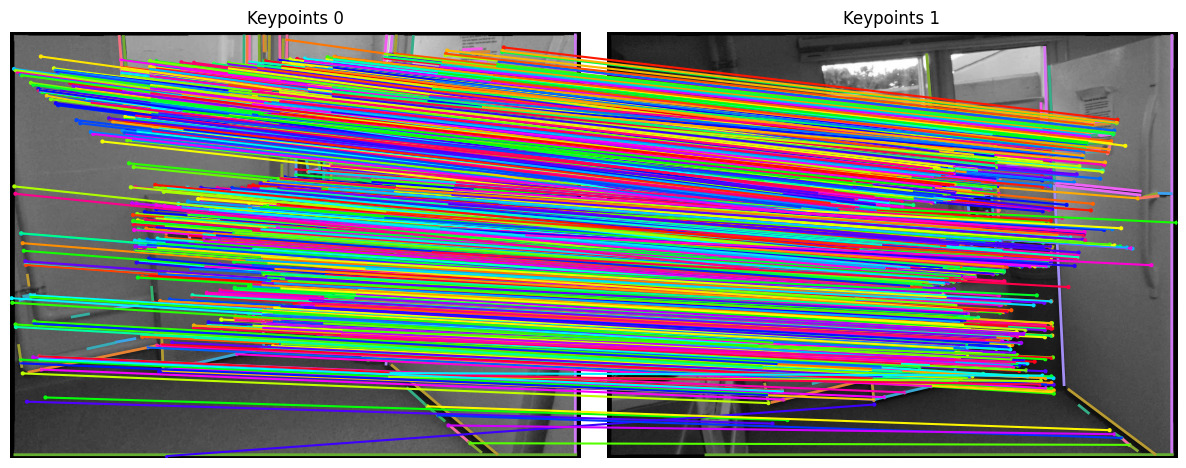

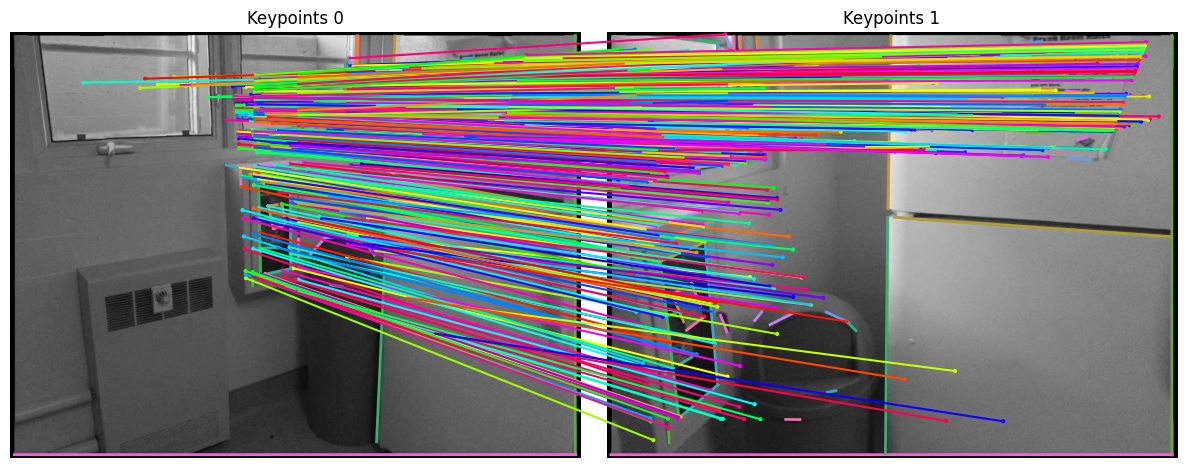

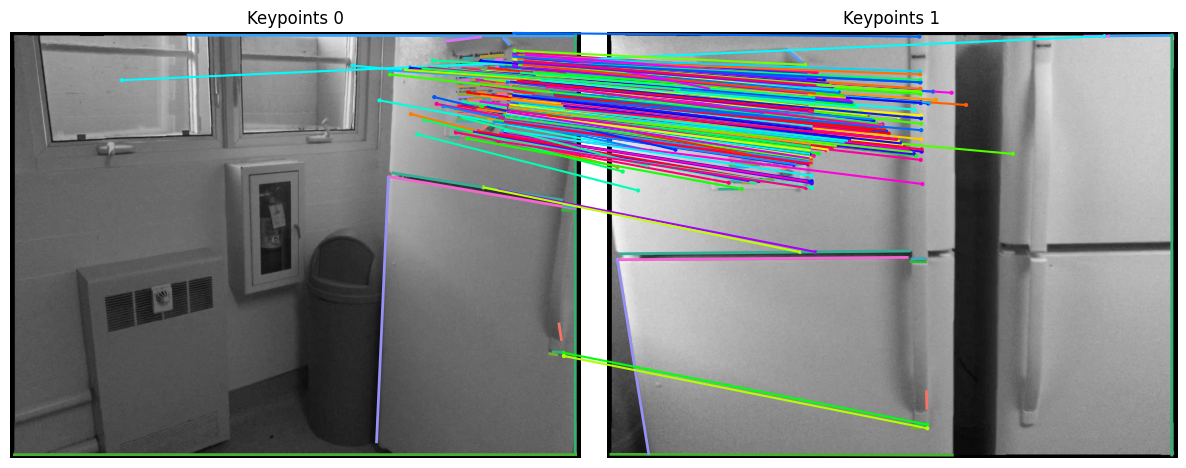

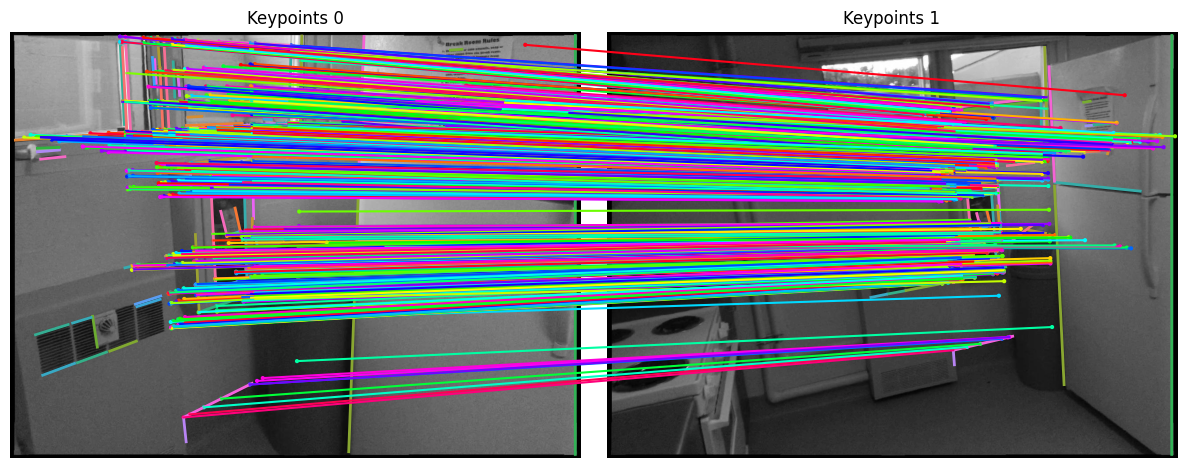

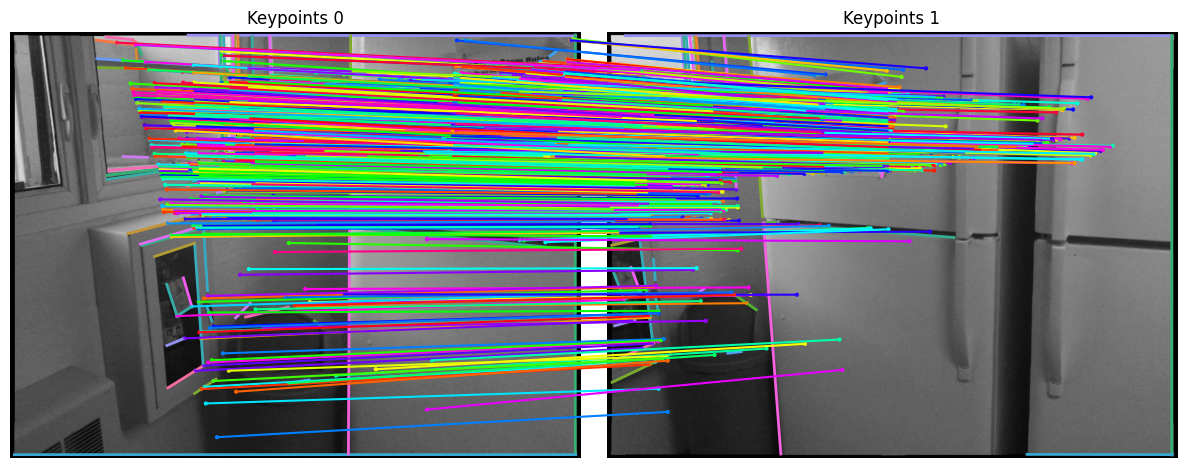

In [35]:
with open(pair_list, "r") as file:
    pair_number = 0
    while True:
        # Get next line from file
        line = file.readline()

        # If line is empty
        # end of file is reached
        if not line:
            break

        items = line.split(" ")
        pair_number += 1

        source_img_name = items[0][11 : 11 + 12] + "_" + items[0][29 : 29 + 12]
        dest_img_name = items[1][11 : 11 + 12] + "_" + items[1][29 : 29 + 12]
        K1 = np.resize(np.array(items[4:13]).astype(np.float64), (3, 3))
        K2 = np.resize(np.array(items[13:22]).astype(np.float64), (3, 3))
        P = np.resize(np.array(items[22:]).astype(np.float64), (4, 4))[:3,:]

        # Iterating through the image pairs in the scene
        processingScene(
            dataset_path,
            depth_path,
            source_img_name, 
            dest_img_name, 
            K1,
            K2, 
            P, 
            matcher,
            f"{output_path}/lines_{matcher_type}_scannet.h5", 
            f"{output_path}/matches_{matcher_type}_scannet.h5", 
            threshold,
            planar_threshold,
            visualize = pair_number <= visualize)

        if visualize > 0 and pair_number > visualize:
            break
    